references

https://www.juanshishido.com/logisticcoefficients.html

https://www.datasklr.com/logistic-regression/multinomial-logistic-regression    

import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from mlxtend.plotting import heatmap

set working directories

In [2]:
in_dir = "N:/SeedsNRI/private/Cornelia/Research Projects/PriceDispersion/Data4_097_v1/ProofCapacityConstraints/"

define functions

In [3]:
def model_params_cleaning(df):
    """ Clean param df
    # param df: df
    # return param df in clean form
    """
    # keep only param for month
    df = df.iloc[0, :]
    
    # transform to df (outcome above is numpy after selection)
    df = pd.DataFrame(df)
    
    # add index as columns
    df = df.reset_index()
    
    # rename vars
    df.rename(columns={'index':'companies', 'month':'coef'}, inplace=True)    
    
    # add 2 to companies column
    
    return df
    df['companies'] = df.companies + 2
    return df

In [4]:
def model_ci_cleaning(np):
    """ Clean ci df
    # param df: df
    # return ci df in clean form
    """
    # keep only CIs for month
    ci_list = []
    for i in range(len(np)):
        ci_list.append(np[i][0])
    # transform to df
    df = pd.DataFrame(ci_list)
    
    # rename vars
    df.columns = ['ci_0', 'ci_1'] 
    
    # add index as column
    df = df.reset_index()
    
    # rename index
    df.rename(columns={'index':'companies'}, inplace=True)
    

    return df

In [5]:
def model_error_bar(df):
    """ Calculate the error bar lenghts for ci
    # param df: params and ci df
    # return params df with added error bar
    """
    error_bar = pd.DataFrame(df.loc[:,'coef'] - df.loc[:,'ci_1'])
    error_bar.rename(columns = {0: 'ci_0'}, inplace=True)
    
    # add params and error_bar to a df
    df = pd.concat((df.loc[:, ['companies', 'coef']], error_bar), axis=1)
    
    return df

#### Step 1: Read in data

In [6]:
fringe = pd.read_stata(in_dir + 'HoD.dta')
core = pd.read_stata(in_dir + 'HeD.dta')

#### Step 2: Data preprocessing

1) keep only columns of interest

In [7]:
columns = ['year',	'state', 'statename', 'fips', 'panel_no', 'companycode', 'companyname', 'parentcode', 'seed_type',
            'IR_single', 'HT_single', 'IR_double', 'IRHT_double', 'IRHT_triple', 'IRHT_quad', 'IRHT_stacked',
            'conventional', 'gmo', 'prior_Jan_order', 'post_Jan_order', 'loyal', 'lon', 'lat', 'month', 'crd']
fringe = fringe[columns]
core =  core[columns]

In [8]:
fringe['seed_desc'] = np.where(fringe.conventional==1, 'conventional',
                              np.where(fringe.IR_single==1, 'IR_single',
                                      np.where(fringe.IR_double==1, 'IR_double',
                                              np.where(fringe.IRHT_double==1, 'IRHT_double',
                                                      np.where(fringe.IRHT_triple==1, 'IRHT_triple',
                                                              np.where(fringe.IRHT_stacked==1, 'IRHT_stacked', 'otherGMO'))))))

core['seed_desc'] = np.where(core.conventional==1, 'conventional',
                              np.where(core.IR_single==1, 'IR_single',
                                      np.where(core.IR_double==1, 'IR_double',
                                              np.where(core.IRHT_double==1, 'IRHT_double',
                                                      np.where(core.IRHT_triple==1, 'IRHT_triple',
                                                              np.where(core.IRHT_stacked==1, 'IRHT_stacked', 'otherGMO'))))))

2) construct 2004-2006, 2007-2009, 2004-2009 panels

In [9]:
# select year panel and region
year = '2004-2006'
region = 'core'
panel = 'yes' # set this to 'no' if no panel is required

In [10]:
year_panel = ['2004-2006', '2007-2009', '2004-2009']
data_region = ['fringe', 'core']

# select based on year
if year == year_panel[0]:
    fringe1 = fringe[fringe.year.le(2006)]
    core1 = core[core.year.le(2006)]
elif year == year_panel[1]:
    fringe1 = fringe[(fringe.year>=2007) & (fringe.year<=2009)]
    core1 = core[(core.year>=2007) & (core.year<=2009)]
else:
    fringe1 = fringe
    core1 = core
    
# select based on date 
if region == data_region[0]:
    df = fringe1
else:
    df = core1
    print('core1')

    
# keep only farmers that have obs in year (i.e., transoform data above into panel)
if panel == 'yes':
    farmer_panel = df.groupby(['panel_no'], as_index=False).agg({'year':'nunique'})
    farmer_panel.rename(columns={'year':'nr_years'},inplace=True)
    df = df.merge(farmer_panel, on='panel_no', how='left')

    # keep if farmer is in all years in year
    if year == year_panel[2]:
        df = df[df.nr_years==6]
    else:
        df = df[df.nr_years==3]

core1


In [11]:
df.head(2)

,year,state,statename,fips,panel_no,companycode,companyname,parentcode,seed_type,IR_single,...,gmo,prior_Jan_order,post_Jan_order,loyal,lon,lat,month,crd,seed_desc,nr_years
11,2004,17,Illinois,17085,176695,774,NORTH-GRO SEEDS,98,1,0.0,...,0.0,1.0,0.0,1.0,90.211983,42.367115,12,17010,conventional,3
19,2004,17,Illinois,17103,123930,174,GARST,3,1,0.0,...,0.0,1.0,0.0,1.0,89.299370,41.746742,12,17010,conventional,3


#### 3) add number of companies a farmer does business with (during the time period selected)

In [12]:
def helper1(grp):
    grp['nr_companies'] = len(np.unique(grp.companycode))
    return grp

df = df.groupby(['panel_no']).apply(helper1)

In [13]:
df.head(2)

,year,state,statename,fips,panel_no,companycode,companyname,parentcode,seed_type,IR_single,...,prior_Jan_order,post_Jan_order,loyal,lon,lat,month,crd,seed_desc,nr_years,nr_companies
11,2004,17,Illinois,17085,176695,774,NORTH-GRO SEEDS,98,1,0.0,...,1.0,0.0,1.0,90.211983,42.367115,12,17010,conventional,3,2
19,2004,17,Illinois,17103,123930,174,GARST,3,1,0.0,...,1.0,0.0,1.0,89.299370,41.746742,12,17010,conventional,3,3


#### Step 3: Summary statistics

1) Average number of orders

In [14]:
# average number of orders
fringe['counts'] = 1
core['counts'] = 1
print('average # of orders in fringe:', fringe.groupby(['year', 'panel_no'], as_index=False)['counts'].count()['counts'].mean())
print('average # of orders in core:', core.groupby(['year', 'panel_no'], as_index=False)['counts'].count()['counts'].mean())

average # of orders in fringe: 4.224709325318358
average # of orders in core: 5.243809362279512


2) average number of seeds

In [15]:
# average number of seeds
temp = fringe.groupby(['year', 'panel_no','seed_type'], as_index=False)['counts'].count()
print('average # of seed types in fringe:',temp.groupby(['year', 'panel_no'], as_index=False)['seed_type'].count()['seed_type'].mean())

temp = core.groupby(['year', 'panel_no','seed_type'], as_index=False)['counts'].count()
print('average # of seed types in core:', temp.groupby(['year', 'panel_no'], as_index=False)['seed_type'].count()['seed_type'].mean())

average # of seed types in fringe: 2.2921774895198923
average # of seed types in core: 2.6183005427408412


3) unique farmers by number of companies

In [16]:
# number unique farmers who buy from 1, 2, 3,... companies
plt1 =df.groupby(['nr_companies'],as_index=False).agg({'panel_no': 'nunique'})
plt1['share'] = plt1.panel_no/df.panel_no.nunique()
plt1.head(20)

,nr_companies,panel_no,share
0,1,122,0.326203
1,2,86,0.229947
2,3,65,0.173797
3,4,52,0.139037
4,5,19,0.050802
5,6,15,0.040107
6,7,10,0.026738
7,8,4,0.010695
8,9,1,0.002674


Text(0, 0.5, 'number of farmers')

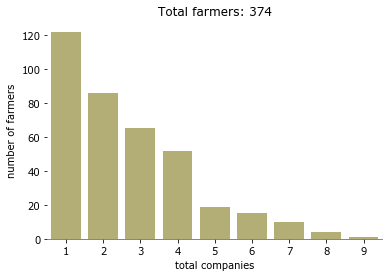

In [17]:
ax = sns.barplot(x="nr_companies", y="panel_no", data=plt1, color='darkkhaki')

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines['bottom'].set_color('dimgrey')

ax.set_title('Total farmers: ' + str(len(df.panel_no.unique())))
ax.set_xlabel('total companies')
ax.set_ylabel('number of farmers')
#ax.set_ylim(0, 130)

3) unique farmers by number of companies and loyal status

In [18]:
# number unique farmers who buy from 1, 2, 3,... companies, by loyal status (aug-dec vs. jan-july)
plt2 =df.groupby(['nr_companies', 'loyal'],as_index=False).agg({'panel_no': 'nunique'})
plt2.rename(columns={'loyal':'order time', 'nr_companies': 'total companies', 'panel_no': 'number of farmers'}, inplace=True)
plt2['order time'] = np.where(plt2['order time']==1, "Aug-Dec", 'Jan-July')
plt2.sort_values(by=['total companies','order time'], ascending=True, inplace=True)
plt2.head(20)

,total companies,order time,number of farmers
1,1,Aug-Dec,105
0,1,Jan-July,47
3,2,Aug-Dec,75
2,2,Jan-July,35
5,3,Aug-Dec,61
4,3,Jan-July,25
7,4,Aug-Dec,44
6,4,Jan-July,21
9,5,Aug-Dec,17
8,5,Jan-July,8


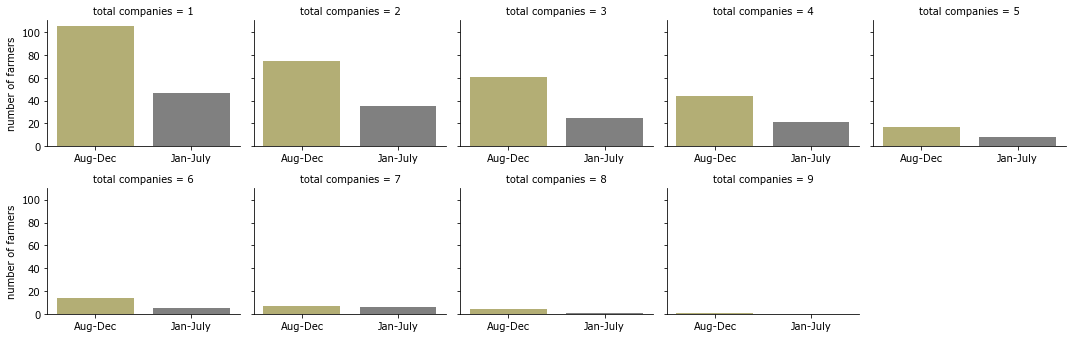

In [19]:
g = sns.catplot(x="order time", y="number of farmers", col='total companies',col_wrap=5, data=plt2,
                kind="bar",  ci=None, aspect=1.2, height=2.5, palette=['darkkhaki', 'grey'], legend=True, sharex=False);
g.set_axis_labels("", "number of farmers")

4) unique farmers by number of companies, loyal status and type of seed

In [20]:
# number unique farmers who buy from 1, 2, 3,... companies, by loyal status (aug-dec vs. jan-july) and type of seed
plt3 =df.groupby(['nr_companies', 'loyal', 'seed_desc'],as_index=False).agg({'panel_no': 'nunique'})
plt3.rename(columns={'loyal':'order time', 'nr_companies': 'total companies', 'panel_no': 'number of farmers', 'seed_desc':'seed type'}, inplace=True)
plt3['order time'] = np.where(plt3['order time']==1, "Aug-Dec", 'Jan-July')
plt3.sort_values(by=['total companies','order time', 'seed type'], ascending=True, inplace=True)
plt3.head()

,total companies,order time,seed type,number of farmers
6,1,Aug-Dec,IRHT_double,62
7,1,Aug-Dec,IRHT_stacked,1
8,1,Aug-Dec,IRHT_triple,16
9,1,Aug-Dec,IR_double,13
10,1,Aug-Dec,IR_single,63


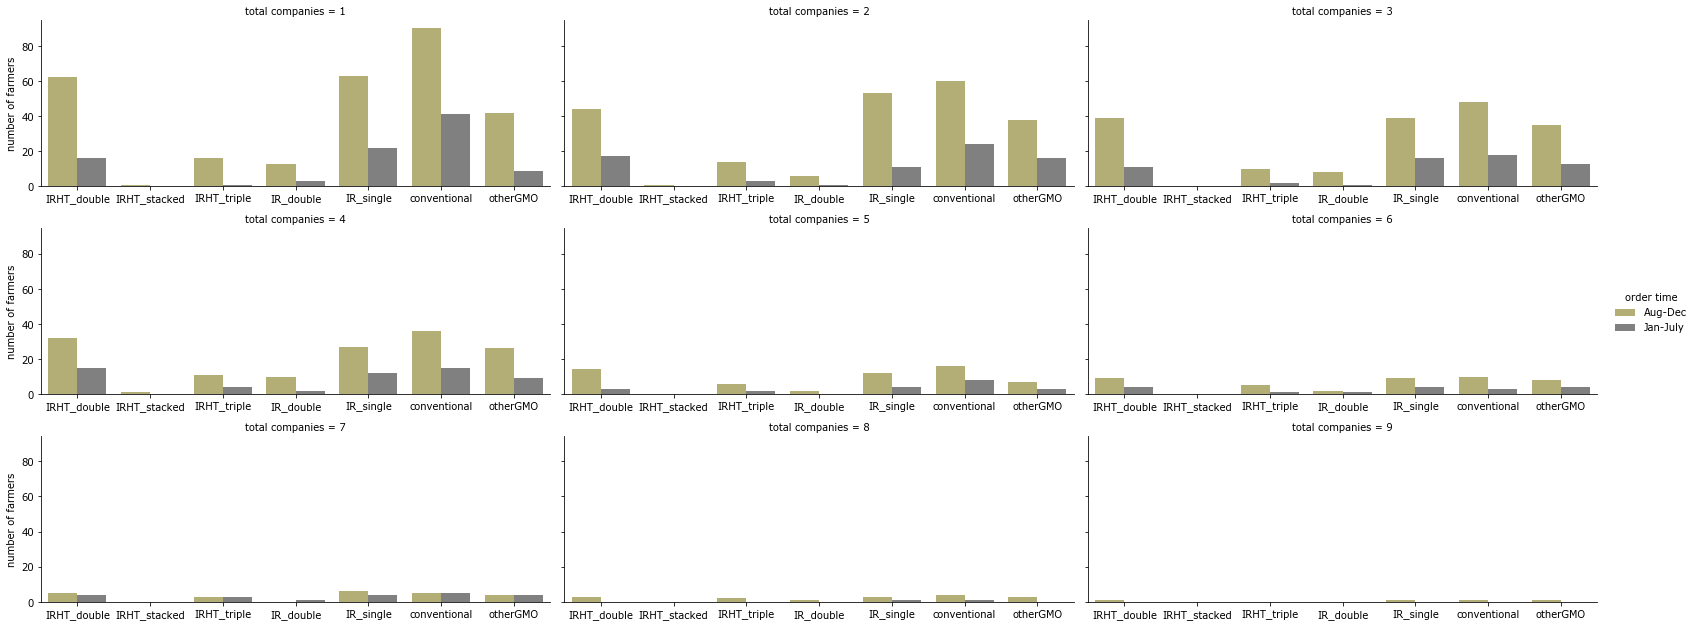

In [21]:
g = sns.catplot(x="seed type", y="number of farmers", hue="order time", col='total companies',col_wrap=3,data=plt3,
                kind="bar", ci=None, aspect=2.5, height=3, palette=['darkkhaki', 'grey'], legend=True, sharex=False)
g.set_axis_labels("", "number of farmers")

5) other stats

In [22]:
## those that bought from 2, 3... companies, did they buy from the same # of companies every year, or the behavior changed over time?
#number of companies per year
plt4 = df.groupby(['nr_companies', 'panel_no', 'year'], as_index=False).agg({'companycode':'nunique'})
plt4.rename(columns={'companycode': 'unique companies per year', 'nr_companies': 'total companies'}, inplace=True)

# example: bougth from 2 companies in 3 year panel: stats by year, number of farmers who bought from 1 company vs 2 companies 
plt4 = plt4.groupby(['total companies', 'year', 'unique companies per year'], as_index=False).agg({'panel_no': 'nunique'})
plt4.head()

,total companies,year,unique companies per year,panel_no
0,1,2004,1,122
1,1,2005,1,122
2,1,2006,1,122
3,2,2004,1,38
4,2,2004,2,48


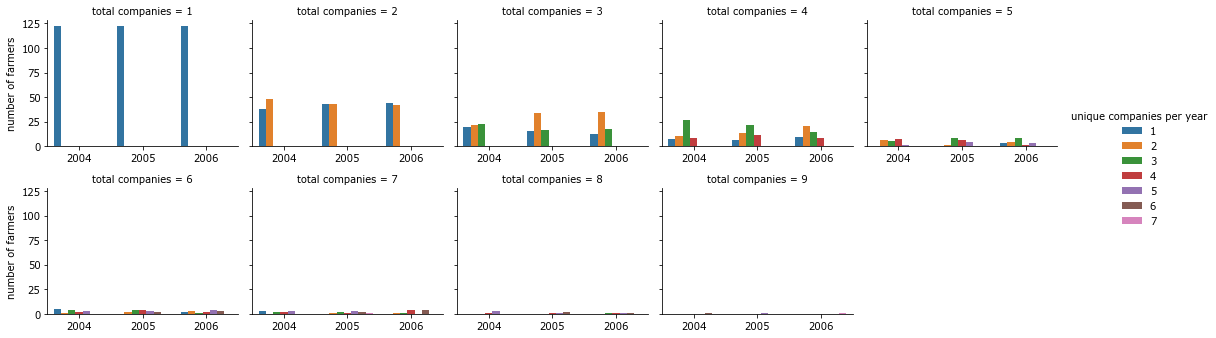

In [23]:
g = sns.catplot(x="year", y="panel_no", hue="unique companies per year", col='total companies',col_wrap=5, data=plt4,
                kind="bar",  ci=None, aspect=1.2, height=2.5, legend=True, sharex=False);
g.set_axis_labels("", "number of farmers")


6) correlation coefficient between #of companies=1 and order before Dec

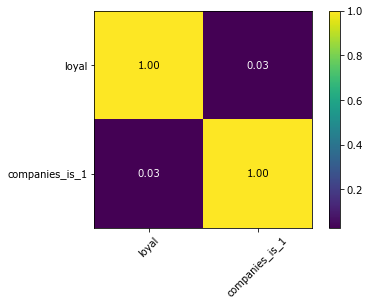

In [24]:
df['companies_is_1'] = np.where(df.nr_companies==1, 1, 0)
# let's add all mobility measures now
features = ['loyal', 'companies_is_1']
cm = df[features].corr().values
hm = heatmap(cm, row_names=features, column_names=features)

#### Step 4: Regression Analysis

1) linear probability model

In [25]:
# create dependent variable
#df_temp = df[(df.nr_companies==1) | (df.nr_companies==2)]
df_temp = df
df_temp['nr_companies'] = np.where(df_temp.nr_companies==1, 1, 0)
y = df_temp["nr_companies"]

# create explanatory variables
X = df_temp[['loyal']]

# create dummy variables     
crd_fe = pd.get_dummies(df["crd"], drop_first = True) 

# join explanatory and dummy variables
X = X.join(crd_fe)

# fit the model
model = sm.OLS(y, X).fit(cov_type ='cluster', cov_kwds={'groups':df_temp['crd']}) 
print(model.summary())

# get predictions (all)
yhat = pd.DataFrame(model.predict(X))

# get predictions (loyal=1)
yhat_loyal = pd.concat([X.iloc[:,0], yhat], axis=1)
yhat_loyal = yhat_loyal[yhat_loyal.loyal==1]
yhat_loyal.rename(columns = {0: 'yhat'}, inplace=True)

# get predictions (loyal = 0)
yhat_notloyal = pd.concat([X.iloc[:,0], yhat], axis=1)
yhat_notloyal = yhat_notloyal[yhat_notloyal.loyal==0]
yhat_notloyal.rename(columns = {0: 'yhat'}, inplace=True)

# print results
print('(yhat_loyal - yhat_notloyal) = ', yhat_loyal.yhat.mean()- yhat_notloyal.yhat.mean())
print('(yhat_loyal - yhat_notloyal)/yhat_notloyal = ', (yhat_loyal.yhat.mean()- yhat_notloyal.yhat.mean())/yhat_notloyal.yhat.mean())

                                 OLS Regression Results                                
Dep. Variable:           nr_companies   R-squared (uncentered):                   0.315
Model:                            OLS   Adj. R-squared (uncentered):              0.312
Method:                 Least Squares   F-statistic:                          1.350e+14
Date:                Tue, 14 Jul 2020   Prob (F-statistic):                   2.29e-170
Time:                        00:48:54   Log-Likelihood:                         -2850.6
No. Observations:                5112   AIC:                                      5753.
Df Residuals:                    5086   BIC:                                      5923.
Df Model:                          26                                                  
Covariance Type:              cluster                                                  
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------

C:\Users\cilin\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 26, but rank is 18
  'rank is %d' % (J, J_), ValueWarning)


2) multinomial logistic regression

In [26]:
# create dependent variable
Y = df["nr_companies"]

# create explanatory variables
X = df[['month']]

# create dummy variables     
crd_fe = pd.get_dummies(df["crd"], drop_first = True) 

# join explanatory and dummy variables
X = X.join(crd_fe)

# create train and test data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.35,
                                                  random_state=1, stratify=Y)

# fit model using sci-kit learn
model2 = LogisticRegression(random_state=0, multi_class='multinomial', penalty='none', solver='newton-cg').fit(X_train, y_train)
print("Prediction performance on train", model2.score(X_train, y_train))
print("Prediction performance on test", model2.score(X_test, y_test))


# fit using statsmodels package
model2 = sm.MNLogit(Y, X).fit(method='bfgs')
#model2.summary()

Prediction performance on train 0.7408187838651414
Prediction performance on test 0.741340782122905
         Current function value: 0.546277
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


C:\Users\cilin\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Text(0, 0.5, 'coeficient estimates: odds_ratio')

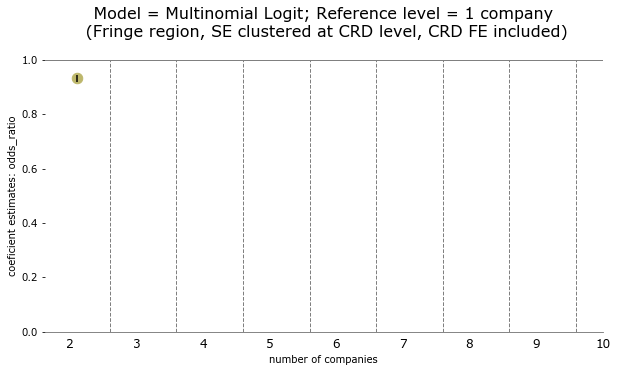

In [27]:
## plot params of multinomial logit model (using statsmodels package)
# get params
params = np.exp(model2.params)
params = model_params_cleaning(params)
    
# get ci
ci = np.exp(model2._results.conf_int())
ci = model_ci_cleaning(ci)

# concat params and ci
param_ci = params.merge(ci, on='companies', how = 'left')

# get params with error bars
coef_df = model_error_bar(param_ci)
coef_df

## markers/labels to use
marker_list = ['o']
marker_color = ['darkkhaki']
#coef_df = coef_df.reset_index()
varname = coef_df.companies.unique()
x_labels = ['2', '3', '4', '5', '6', '7', '8', '9', '10']

width = 0.10

## define x base (4 covariates in total)
base_x = pd.np.arange(len(varname)) 
base_x

# plot graphs
fig, ax = plt.subplots(figsize=(10, 5))
    
# sort params in order
coef_df = coef_df.set_index('companies').reindex(varname)
    
# plot bars
X = base_x + width 
ax.bar(X, coef_df['coef'], color='none', yerr=coef_df['ci_0'], width=0.2)
    
# plot markers
ax.scatter(x=X,  marker=marker_list[0], s=110, 
               y=coef_df['coef'], color=marker_color[0])

# add vertical and horizontal lines
ax.axhline(y=1, linewidth=1, color='grey')
ax.axvline(x=0.6, linestyle='--', linewidth=1, color='grey')
ax.axvline(x=1.6, linestyle='--', linewidth=1, color='grey')
ax.axvline(x=2.6, linestyle='--', linewidth=1, color='grey')
ax.axvline(x=3.6, linestyle='--', linewidth=1, color='grey')
ax.axvline(x=4.6, linestyle='--', linewidth=1, color='grey')
ax.axvline(x=5.6, linestyle='--', linewidth=1, color='grey')
ax.axvline(x=6.6, linestyle='--', linewidth=1, color='grey')
ax.axvline(x=7.6, linestyle='--', linewidth=1, color='grey')

# set ax visibility
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines['bottom'].set_color('dimgrey')

# add title, labels, legend 
ax.set_title(' Model = Multinomial Logit; Reference level = 1 company \n (Fringe region, SE clustered at CRD level, CRD FE included)\n', fontsize=16)
ax.xaxis.set_ticks_position('none')
ax.set_xticks(np.arange(len(x_labels)))
ax.set_xticklabels(x_labels, rotation=0, fontsize=12)
#ax.set_ylim(0.5, 1.2)
#ax.set_yticks(np.arange(0.5, 1.3, 0.2))
plt.xlabel('number of companies')
plt.ylabel('coeficient estimates: odds_ratio')

#### Step 5: Bayes rule

In [28]:
df['counts'] = 1

compute posterior probabilities

In [29]:
post_prob = df.groupby(['year'], as_index=False)['counts'].count()
post_prob['post_prob'] = post_prob.counts/df.shape[0]
post_prob.head()

,year,counts,post_prob
0,2004,1673,0.327269
1,2005,1824,0.356808
2,2006,1615,0.315923


compute conditional probabilities

In [30]:
cond_prob = df.groupby(['year', 'nr_companies'], as_index=False)['counts'].count()

temp = cond_prob.groupby(['year'], as_index=False)['counts'].sum()

cond_prob['counts_year'] = np.where(cond_prob.year==2004, temp[temp.year==2004].counts.values, 
                                   np.where(cond_prob.year==2005, temp[temp.year==2005].counts.values, temp[temp.year==2006].counts.values))

cond_prob['cond_prob'] = cond_prob.counts/cond_prob.counts_year

# keep only for one company
cond_prob = cond_prob[cond_prob.nr_companies==1]

compute conditional probabilities x posterior probabilities

In [31]:
numerator = cond_prob.merge(post_prob, on='year', how='left')
numerator['cond_post_prob'] = numerator.cond_prob * numerator.post_prob
numerator.head()

,year,nr_companies,counts_x,counts_year,cond_prob,counts_y,post_prob,cond_post_prob
0,2004,1,446,1673,0.266587,1673,0.327269,0.087246
1,2005,1,464,1824,0.254386,1824,0.356808,0.090767
2,2006,1,423,1615,0.261920,1615,0.315923,0.082746


In [32]:
denominator = 0
for i in numerator.index:
    denominator += numerator.loc[i, 'cond_post_prob']

In [33]:
numerator.cond_post_prob/denominator

0    0.334584
1    0.348087
2    0.317329
Name: cond_post_prob, dtype: float64